In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
# if available, use gpu for training
use_gpu = True
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
print(f"Device: {device}")

# %env CUDA_LAUNCH_BLOCKING=1

Device: cuda:0


In [3]:
DATASET_PATH ="/home/samarthramesh/Work/Build-NNs/data/face_data/lfw-deepfunneled/lfw-deepfunneled/"

In [4]:
dataset = {"person" : [], "path" : []}
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset["person"].append(person)
    dataset["path"].append(path)
    
dataset = pd.DataFrame(dataset)
# remove people with too many images
# todo: randomly select which images to keep and discard excess
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
1,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
2,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
3,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
4,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
5,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
6,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
7,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
8,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...
9,Abdullah_Gul,/home/samarthramesh/Work/Build-NNs/data/face_d...


In [5]:
class FaceDataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, index):
        data_point = self.data_df.iloc[index]
        name = data_point["person"]
        face = read_image(data_point["path"])
        return face, name

In [6]:
train_dataloader = DataLoader(FaceDataset(dataset), batch_size=32, shuffle=True)

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        # print("Intialising Linear Layer")
    elif isinstance(m , nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        # print("Initialising Convolutional Layer")
        
def calc_output_res(image_res, num_layers, kernel_sizes, strides, paddings, raise_error = True, print_res = False):
    for i in range(num_layers):
        image_res = ((image_res-kernel_sizes[i]+2*paddings[i])/strides[i]) + 1
        if print_res:
            print(image_res)
    if raise_error and not image_res.is_integer():
        raise ValueError("Convolution Layer is losing pixels")
    return int(image_res)

class VAE(nn.Module):
    def __init__(self, in_channels, image_res, latent_dim, hidden_dims = None, kernel_sizes=None, strides=None, paddings=None):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims

        if self.hidden_dims is None:
            self.hidden_dims = [32, 64, 128, 256]

        encoder_modules = []
        for i, dim in enumerate(self.hidden_dims):
            encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        dim,
                        kernel_size=kernel_sizes[i],
                        stride=strides[i],
                        padding=paddings[i]
                    ),
                    nn.BatchNorm2d(dim),
                    nn.ReLU()
                )
            )
            in_channels = dim


        self.encoder_output_res = calc_output_res(image_res, len(self.hidden_dims), kernel_sizes, strides, paddings)
        if self.encoder_output_res <= 0:
            raise ValueError("Too Many Convolution Layers. Output Image is reduced to nothing.")

        self.encoder = nn.Sequential(*encoder_modules)
        self.fc_mean = nn.Linear(self.hidden_dims[-1]*(self.encoder_output_res**2), self.latent_dim)
        self.fc_log_vars = nn.Linear(self.hidden_dims[-1]*(self.encoder_output_res**2), self.latent_dim)

        self.decoder_input = nn.Linear(self.latent_dim, self.hidden_dims[-1]*(self.encoder_output_res**2))

        num_layers = len(self.hidden_dims) - 1
        decoder_modules = []
        for i in range(len(self.hidden_dims)-1):
            decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        self.hidden_dims[num_layers-i],
                        self.hidden_dims[num_layers-(i+1)],
                        kernel_size=kernel_sizes[num_layers-i],
                        stride=strides[num_layers-i],
                        padding=paddings[num_layers-i],
                        # output_padding=paddings[num_layers-i]
                        output_padding=0
                    ),
                    nn.BatchNorm2d(self.hidden_dims[num_layers-(i+1)]),
                    nn.ReLU()
                )
            )

        self.decoder = nn.Sequential(*decoder_modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                self.hidden_dims[0],
                self.hidden_dims[0],
                kernel_size=kernel_sizes[0],
                stride=strides[0],
                padding=paddings[0],
                # output_padding=paddings[0]
                output_padding=0
            ),
            nn.BatchNorm2d(self.hidden_dims[0]),
            nn.ReLU(),
            nn.Conv2d(
                self.hidden_dims[0],
                3,
                kernel_size=3,
                padding=1
            ),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        z_mean = self.fc_mean(x)
        z_log_vars = self.fc_log_vars(x)

        z = self.reparameterise(z_mean, z_log_vars)
        return z, z_mean, z_log_vars

    def decode(self, z):
        out = self.decoder_input(z)
        out = out.view(-1, self.hidden_dims[-1], self.encoder_output_res, self.encoder_output_res)
        out = self.decoder(out)
        out = self.final_layer(out)
        return out

    def reparameterise(self, z_mean, z_log_vars):
        std = torch.exp(0.5 * z_log_vars)
        z = torch.randn_like(std)
        z = z.mul(std).add_(z_mean)
        return z
    
    def forward(self, x):
        z, z_mean, z_log_vars = self.encode(x)
        out = self.decode(z)
        return out, z_mean, z_log_vars
    
    def sample(self, num_samples, device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(device)
        out = self.decode(z)
        return out
    
def elbo_loss(inputs, outputs, z_mean, z_log_vars, beta=1):
    bce = F.binary_cross_entropy(outputs, inputs, reduction="sum")
    kld = -0.5 * torch.sum(1 + z_log_vars - z_mean.pow(2) - z_log_vars.exp())
    return bce + beta*kld

In [8]:
num_epochs = 5
batch_size = 64
opt = "adam"
lr = 0.01
latent_dim = 1000
hidden_dims=[32, 32, 32, 64, 64, 64]
kernel_sizes = [4,3,3,4,4,4]
strides = [2,2,2,2,2,2]
paddings = [1,1,1,1,1,1]

In [9]:
vae = VAE(3, 250, latent_dim, hidden_dims=hidden_dims, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings)
vae.apply(init_weights)
vae.to(device)
print(f"Number of parameters: {sum(p.numel() for p in vae.parameters())}")

if opt == "sgd":
    optimizer = optim.SGD(vae.parameters(), lr=lr, momentum=0.9)
elif opt == "adam":
    optimizer = optim.Adam(vae.parameters(), lr=lr)
else:
    raise ValueError("Value for opt parameter is not valid.")

train_dataloader = DataLoader(FaceDataset(dataset), batch_size=batch_size, shuffle=True)

Number of parameters: 3459987


In [10]:
epoch_losses = []
for epoch in range(num_epochs):
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = (inputs/255).to(device)
        optimizer.zero_grad()

        outputs, mean, log_vars = vae.forward(inputs)
        loss = elbo_loss(inputs, outputs, mean, log_vars)
        # print(loss.shape)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
    
    epoch_loss = np.average(train_losses)
    epoch_losses.append(epoch_loss)    
    print(f"Epoch {epoch+1} - Train Loss: {epoch_loss}")

Epoch 1 - Train Loss: 3890990889.6212573
Epoch 2 - Train Loss: 7360859.345808383
Epoch 3 - Train Loss: 7277591.266467066
Epoch 4 - Train Loss: 7181360.28742515
Epoch 5 - Train Loss: 7110296.767964072


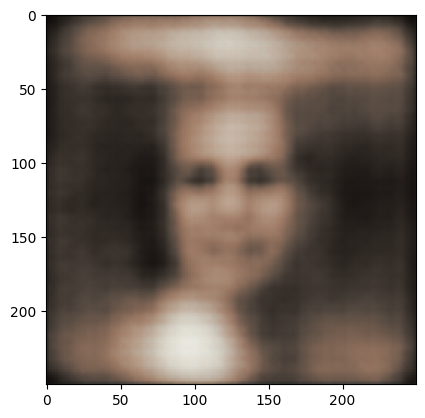

In [21]:
plt.imshow(torch.squeeze(vae.sample(1, device).detach().cpu()).permute(1, 2, 0))
plt.show()

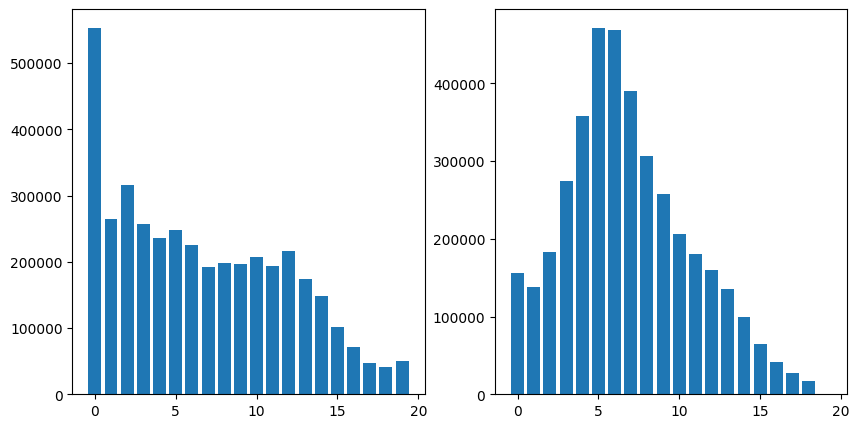

In [12]:
hist1 = torch.histc(inputs.cpu(), bins = 20, min = 0, max = 1)
hist2 = torch.histc(outputs.cpu(), bins = 20, min = 0, max = 1)

bins = 20
x = range(bins)
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].bar(x, hist1, align='center')
axs[1].bar(x, hist2, align='center')
plt.show()

In [13]:
hidden_dims=[32, 32, 64, 64, 64]
kernel_sizes = [4,3,3,4,4]
strides = [2,2,2,2,2]
paddings = [1,1,1,1,1]

calc_output_res(250, len(hidden_dims), kernel_sizes, strides, paddings, raise_error=False, print_res=True)

125.0
63.0
32.0
16.0
8.0


8